In [1]:
import os
import sys
import random
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import albumentations as A
from skimage.morphology import remove_small_objects


# Root directory of the project
ROOT_DIR = os.path.abspath(os.getcwd())

# Import Mask RCNN 
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn import stats_utils

import Monuseg_dist

%matplotlib inline 
%load_ext autoreload
%autoreload 2

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

MONUSEG_DIR = os.path.join(ROOT_DIR, "datasets\\Monuseg_dist")
config = Monuseg_dist.MonusegDIST_H_InferenceConfig()


c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' 

In [2]:
# Load dataset - 
subset = "val"
dataset_dir = os.path.join(MONUSEG_DIR, subset)
image_dir = os.path.join(dataset_dir, "tissue_images")
#image_dir = os.path.join(dataset_dir, "macenko")

image_ids = os.listdir(image_dir)
print("Found {} images in {}".format(len(image_ids), image_dir))


dataset = Monuseg_dist.MonusegDISTDataset("UNET")
dataset.add_class(source = "Monuseg", class_id =  1, class_name = "nucleus")

# Fill with the samples
i = 0
for _id in image_ids:
    name,_ = os.path.splitext(_id)
    if i <= len(image_ids):
        dataset.add_image(source = "Monuseg",
                                image_id = name,
                                path = os.path.join(image_dir, _id))
    i+=1    

    
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Found 14 images in C:\Users\User\GitHub\Improved Mask R-CNN\datasets\Monuseg_dist\val\tissue_images
Image Count: 14
Class Count: 2
  0. BG                                                
  1. nucleus                                           


In [3]:
# Load model
DEVICE = "/gpu:0" #  "/gpu:0"
TEST_MODE = "inference"

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
    
# PATH
weights_path = r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_pannuke_1x120210630T0837\mask_rcnn_monuseg_dist_gt_pannuke_1x1_0050.h5"

print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_pannuke_1x120210630T0837\mask_rcnn_monuseg_dist_gt_pannuke_1x1_0050.h5
Re-starting from epoch 50


In [4]:
# Set up augmentations:
# 4 Images: Original, flipped Vert, flipped Hori , Hue Saturated

augmentations = []
augmentations.append(A.Compose([A.HorizontalFlip(always_apply=True)], additional_targets={'dist': 'mask', 'Hch':'mask'}))
augmentations.append(A.Compose([A.VerticalFlip(always_apply=True)], additional_targets={'dist': 'mask', 'Hch':'mask'}))
augmentations.append(A.Compose([A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, always_apply=True)], additional_targets={'dist': 'mask', 'Hch':'mask'}))

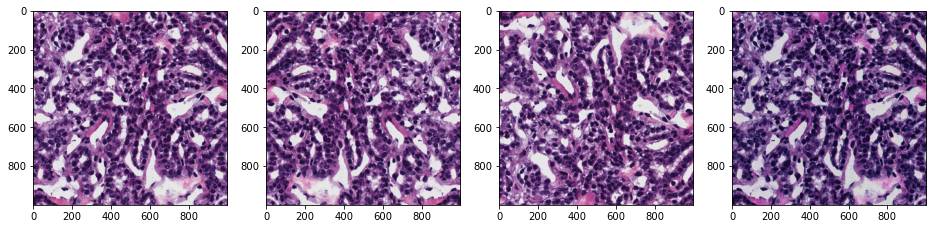

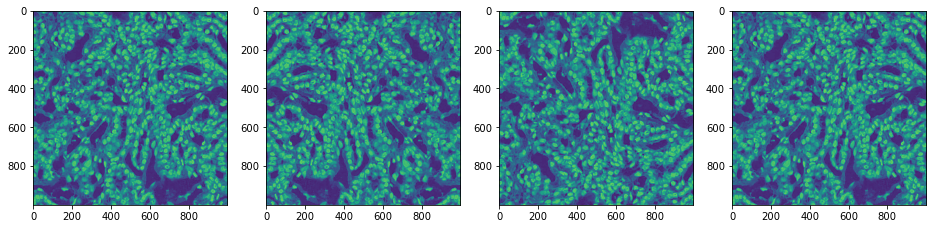

In [5]:
#source = "TCGA-HT-8564-01Z-00-DX1"
#_id = dataset.image_from_source_map["Monuseg.{}".format(source)]
_id = 0

config.IMAGE_RESIZE_MODE = "pad64"
orig_image = dataset.load_image(_id)
image_list = []
image_list.append(orig_image)
hch = orig_image[:,:,4]
dist = orig_image[:,:,3]
rgb_image = orig_image[:,:,0:3]

# Get augmented images:
for aug in augmentations:
    augmented = aug(image = rgb_image, dist = dist, Hch = hch)
    final = np.zeros(orig_image.shape, dtype = np.uint8)
    final[:,:,0:3] = augmented['image']
    final[:,:,3] = augmented['dist']
    final[:,:,4] = augmented['Hch']
    image_list.append(final.copy())

# Display them
fig, axs = plt.subplots(1,4, figsize=(16, 16))
i = 0
for ax in np.ravel(axs):
    ax.imshow(image_list[i][:,:,0:3])
    i+=1

fig, axs = plt.subplots(1,4, figsize=(16, 16))
i = 0
for ax in np.ravel(axs):
    ax.imshow(image_list[i][:,:,4])
    i+=1

In [6]:
#Run detection, get non binarized masks for merging:
results = []
for image in image_list:
    r = model.detect([image], verbose = False, binarize = False)[0]
    # Rescale dtype to uint8 for performance/memory
    r["masks"] = (r["masks"] / np.max(r["masks"])) * 255
    r["masks"] = r["masks"].astype(np.uint8)
    results.append(r)

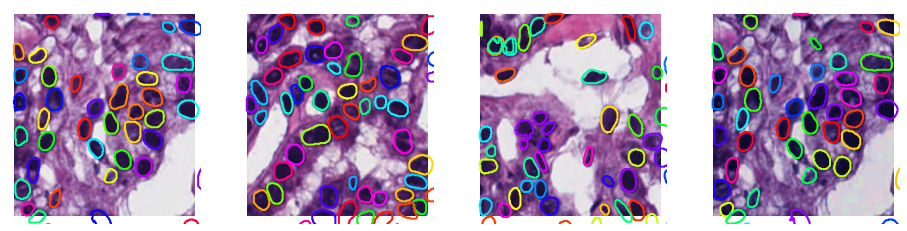

In [7]:
fig, axs = plt.subplots(1,4, figsize=(16, 4))
i = 0
#display_instances(image, boxes, masks, class_ids, class_names,use_captions)
for ax in np.ravel(axs):
    visualize.display_instances(image_list[i][0:256,0:256,0:3], results[i]["rois"], results[i]["masks"] > 0.7*255, results[i]["class_ids"],
                                dataset.class_names, show_bbox=False, show_mask=False, use_captions = False, ax = ax)
    i+=1

In [8]:
# Merge the results: Put everything back into one image space - reverse flips
for i in [1,2]:
    aug = augmentations[i-1]
    augmented = aug(image = image_list[i], mask = results[i]["masks"].astype(np.int8), bboxes = results[i]["rois"])
    image_list[i] = augmented["image"]
    results[i]["masks"] = augmented["mask"].astype(np.uint8)# > (255*0.7)
    results[i]["rois"] = utils.extract_bboxes(results[i]["masks"] > (255*0.7))
    

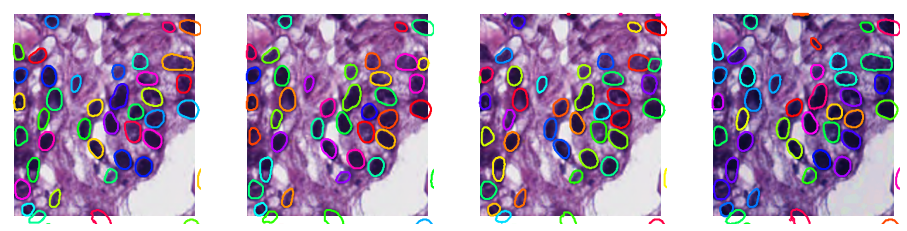

In [9]:
fig, axs = plt.subplots(1,4, figsize=(16, 4))
i = 0
#display_instances(image, boxes, masks, class_ids, class_names,use_captions)
for ax in np.ravel(axs):
        visualize.display_instances(image_list[i][0:256,0:256,0:3], results[i]["rois"], results[i]["masks"] > (255*0.7), results[i]["class_ids"],
                                dataset.class_names, show_bbox=False, show_mask=False, use_captions = False, ax = ax)
        i+=1

mask dtype != bool detected, using 0.7*max as threshod
mask dtype != bool detected, using 0.7*max as threshod
mask dtype != bool detected, using 0.7*max as threshod
mask dtype != bool detected, using 0.7*max as threshod


C:\Users\User\GitHub\Improved Mask R-CNN\mrcnn\utils.py:79: RuntimeWarning: invalid value encountered in true_divide
  iou = intersection / union


Merged instances: 750


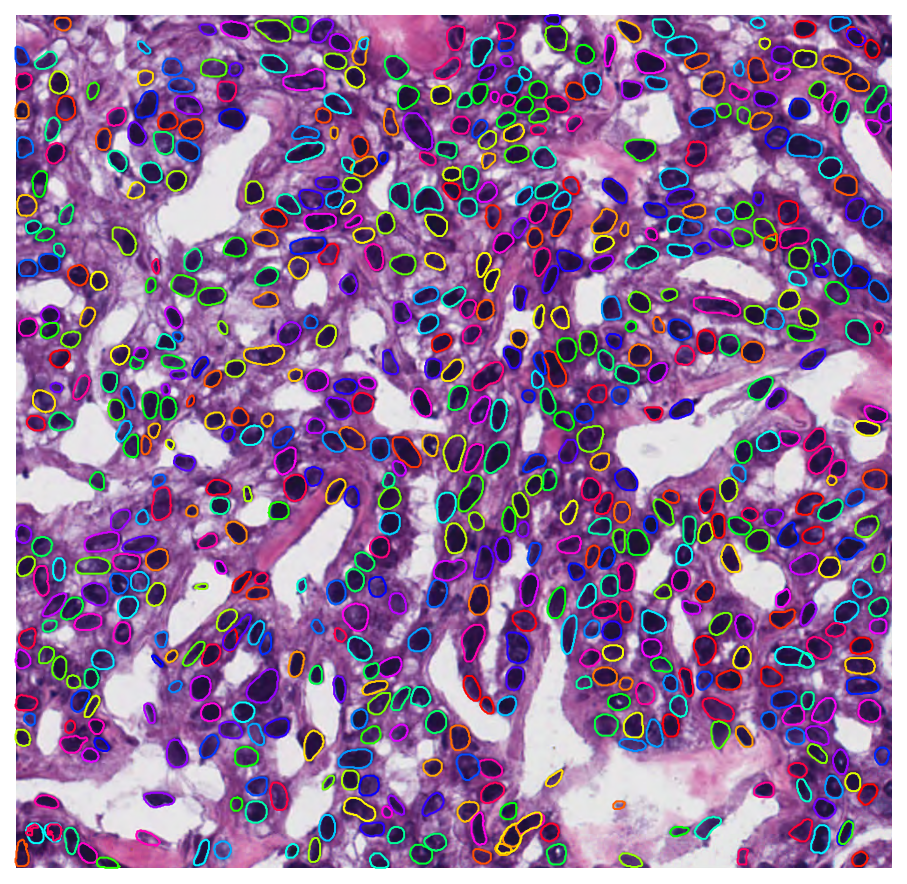

(0.6088942635355467, 0.5932494812997098)


In [10]:
# Perform simple merge via NMS
nms_mask, bbox, scores = utils.simple_merge_TTA(results)
remove_small_objects(nms_mask, min_size=50, in_place=True)

print("Merged instances: " + str(nms_mask.shape[-1]))
visualize.display_instances(image_list[0][:,:,0:3], bbox, nms_mask, np.ones(nms_mask.shape[-1]), 
                            dataset.class_names, show_bbox = False, show_mask=False, use_captions = False)

gt_mask = dataset.load_mask(_id)[0]
print(utils.calc_aji_pq(nms_mask, gt_mask))

In [11]:
# Put it all together, perform Mask Merge
_all_masks = []
for r in results:
    _all_masks.append(r["masks"])

_all_masks = np.concatenate(_all_masks, axis = -1)
print(_all_masks.shape, _all_masks.dtype)

merge_mask = utils.mask_merge2(_all_masks)
remove_small_objects(merge_mask, min_size=50, in_place=True)
print(utils.calc_aji_pq(merge_mask, gt_mask))

(1000, 1000, 2698) uint8
(0.6203526654781759, 0.6084058327929073)
